In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2010-10-01,17.16,16.98,17.16,16.85,30.36,0.00
1,2010-10-04,16.98,17.05,17.07,16.73,47.29,0.43
2,2010-10-05,16.99,16.82,17.00,16.82,36.29,-1.38
3,2010-10-06,16.87,16.50,16.93,16.50,48.64,-1.88
4,2010-10-07,15.72,15.84,16.05,15.67,271.00,-4.00


### Shift label column

In [3]:
for i in range(1, 31):
    name = 'Otwarcie_' + str(i) + 'day'
    df[name] = df['Otwarcie'].shift(-i)
    name = 'Zamknięcie_' + str(i) + 'day'
    df[name] = df['Zamknięcie'].shift(i)

### Drop invalid samples

In [4]:
df = df.iloc[31:]
df = df[:-30]
df.index = range(len(df))

### Split data

In [5]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.show()

### Drop unnecessary columns

In [6]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)', 'Otwarcie', 'Min', 'Maks']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

## 1 day ahead

7 days of history data

In [7]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune SVR Regressor

In [8]:
parameters = {'kernel': ['rbf'],
 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
 'C': [1, 10, 100, 1000, 10000]}

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=SVR(epsilon = 0.01),
    param_grid=parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}

In [9]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.0070764522980200995
MAE = 0.05254449558356891
RMSE = 0.084121651778957


In [11]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

30 days of history data

In [12]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune SVR Regressor

In [13]:
parameters = {'kernel': ['rbf'],
 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
 'C': [1, 10, 100, 1000, 10000]}

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=SVR(epsilon = 0.01),
    param_grid=parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}

In [14]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.00728987095655788
MAE = 0.05442075497267137
RMSE = 0.08538074113380535


In [16]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

## 7 days ahead

7 days of history data

In [17]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune SVR Regressor

In [19]:
model = MultiOutputRegressor(SVR(epsilon = 0.01))
hyperparameters = dict(estimator__kernel=['rbf'], 
                     estimator__gamma=[1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                     estimator__C=[1, 10, 100, 1000, 10000])
tscv = TimeSeriesSplit(n_splits=3)
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__kernel': 'rbf', 'estimator__gamma': 0.01, 'estimator__C': 1000}


In [20]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [21]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.2067022380325016
MAE = 0.3270553455218103
RMSE = 0.4546451781691978


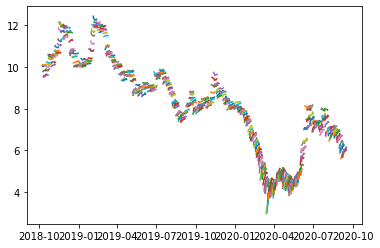

In [22]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)

30 days of history data

In [23]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune SVR Regressor

In [24]:
model = MultiOutputRegressor(SVR(epsilon = 0.01))
hyperparameters = dict(estimator__kernel=['rbf'], 
                     estimator__gamma=[1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                     estimator__C=[1, 10, 100, 1000, 10000])
tscv = TimeSeriesSplit(n_splits=3)
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__kernel': 'rbf', 'estimator__gamma': 0.1, 'estimator__C': 100}


In [25]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [26]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 4.97997225560825
MAE = 1.2723101918403488
RMSE = 2.23158514415387


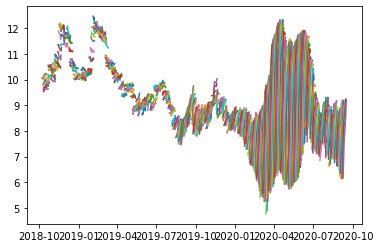

In [27]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)